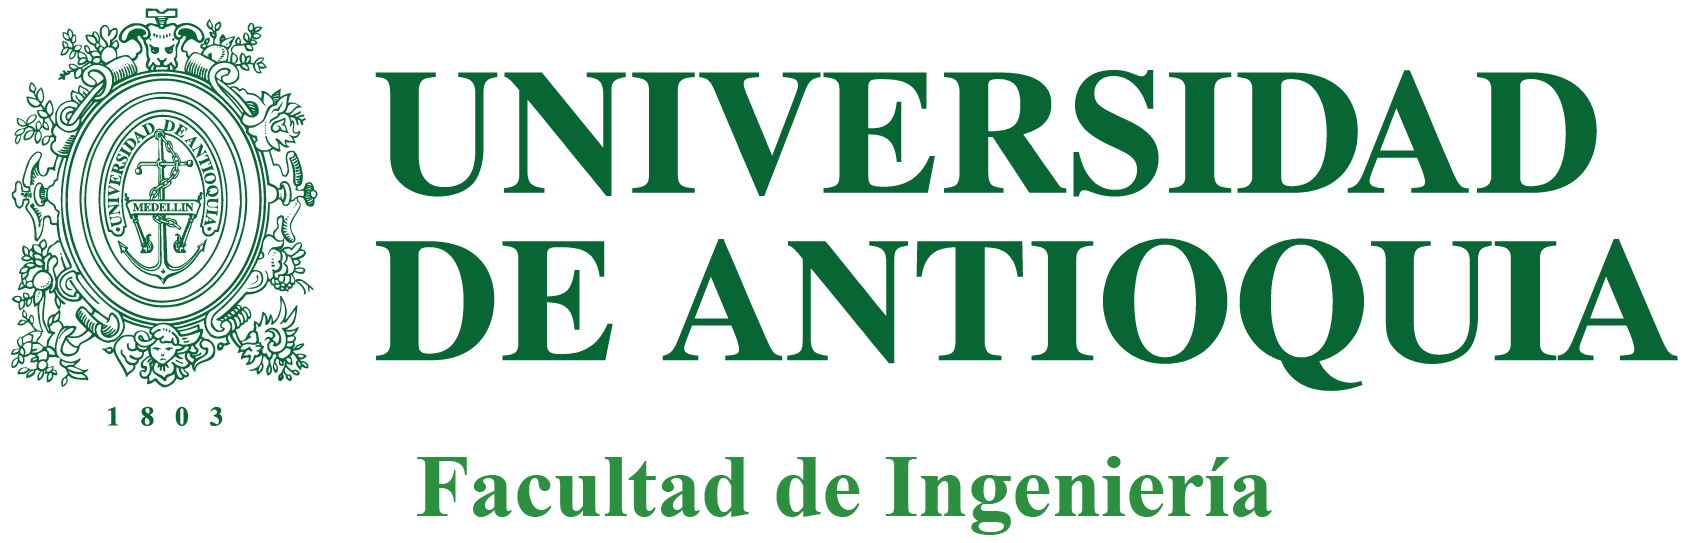

# <font color='2d9040'>**Identificación aplicando técnicas paramétricas.**</font>
## Grupo de trabajo 1 (M14-16):
 - Sofía Raigosa.
 - Omar Acevedo.
 - Juan Esteban Pineda.

**Objetivo:** *Comprender e implementar las técnicas de identificación paramétricas haciendo una selección adecuada de la estructura y orden del modelo.*

**Problema:** *Como resultado de una investigación se registraron datos de entrada y salida de un sistema, por lo que se desea identificar un modelo lineal paramétrico que lo represente.*

## Importación de las librerias.

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.fft import fft, fftfreq
from pysid import bj, armax, oe, arma, ar, arx
from scipy.signal import find_peaks, dlti, dlsim
from scipy.stats import pearsonr

## Caracterización de los datos.

In [33]:
# Cargar el archivo
data = pd.read_csv('D1.csv')
data.head()

,t,u,y,uv,yv
0,0.00,5.000000,0.000000,1,0.000000
1,0.01,5.199987,-0.482499,1,-0.561122
2,0.02,5.399893,1.201891,1,1.043382
3,0.03,5.599640,-0.619401,1,-0.859049
4,0.04,5.799147,1.043678,1,0.721644


In [34]:
# Vector de tiempo
t = np.array(data.t)
Ts = np.mean(np.diff(t))
print(f'Periodo de muestreo: {Ts}')

# Vectores de salida (y) y entrada (u) para construcción.
u = np.array(data.u)
y = np.array(data.y)

# Vectores de salida (yv) y entrada (uv) para validación.
uv = np.array(data.uv)
yv = np.array(data.yv)

Periodo de muestreo: 0.01


### Graficación de los datos.
---

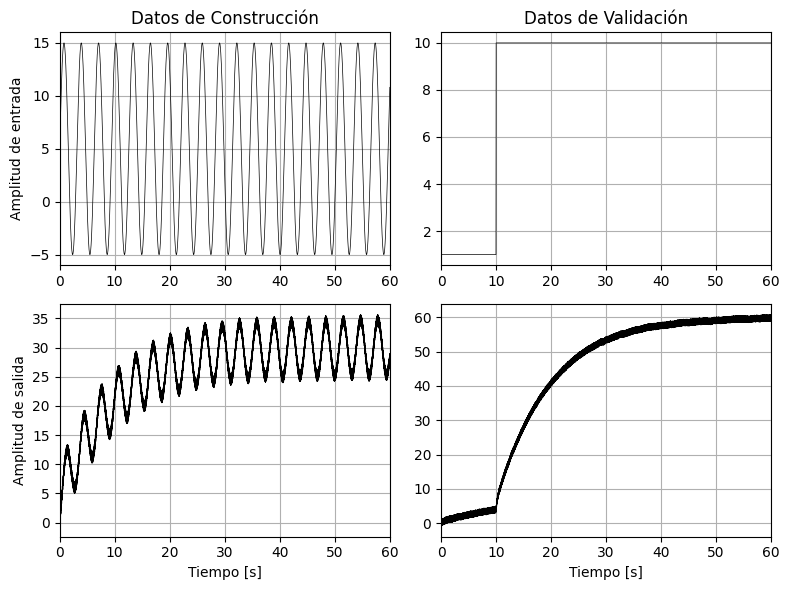

In [35]:
plt.figure(figsize=(8,6))

# Entrada de construcción.
plt.subplot(2, 2, 1)
plt.plot(t, u, color='black', linewidth=0.5)
plt.title('Datos de Construcción')
plt.ylabel('Amplitud de entrada')
plt.xlim(0, np.max(t))
plt.grid(True)

# Entrada de validación.
plt.subplot(2, 2, 2)
plt.plot(t, uv, color='black', linewidth=0.5)
plt.title('Datos de Validación')
plt.xlim(0, np.max(t))
plt.grid(True)

# Salida de construcción.
plt.subplot(2, 2, 3)
plt.plot(t, y, color='black', linewidth=0.5)
plt.ylabel('Amplitud de salida')
plt.xlabel('Tiempo [s]')
plt.xlim(0, np.max(t))
plt.grid(True)

# Salida de validación.
plt.subplot(2, 2, 4)
plt.plot(t, yv, color='black', linewidth=0.5)
plt.xlabel('Tiempo [s]')
plt.xlim(0, np.max(t))
plt.grid(True)

plt.tight_layout()
plt.show()

No se evidencian retardos importantes en la respuesta respecto a la entrada, por lo que al momento de evaluar los modelos, **se justifica considerar $n_k$ bajos**. Adicionalmente, puede evidenciarse la aparición de ruido en ambas salidas a través del aparente "engrosamiento" de las lineas. Esto se confirmará al evaluar el espectro en frecuencia de los vectores.

### Caracterización de la frecuencia.
---

In [36]:
N = len(y)
freq = fftfreq(N, Ts)[:N//2]

yf = fft(y)
uf = fft(u)
yvf = fft(yv)
uvf = fft(uv)

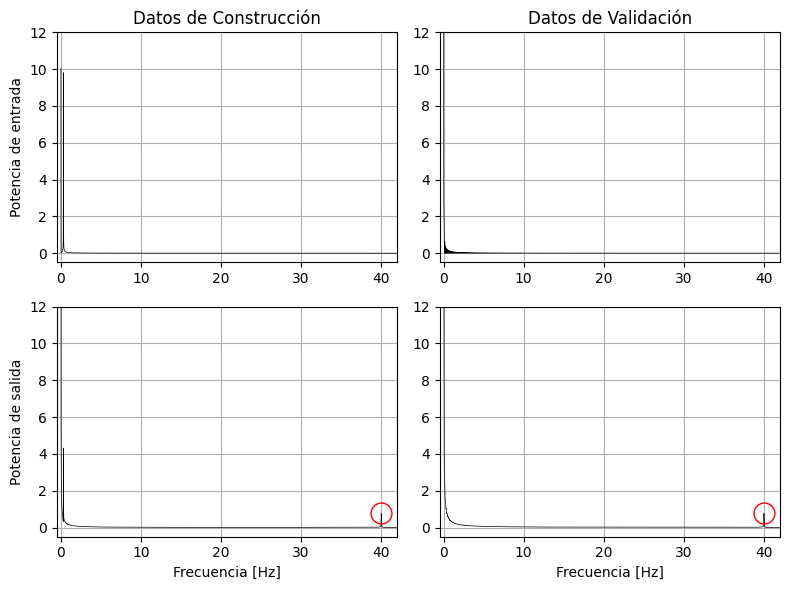

---------------- Caracterización del ruido -----------------
Frecuencia = 39.9933Hz
Potencia = 0.7618
Amplitud = 0.8728



In [37]:
# Magnitudes
yf_mag = 2.0/N * np.abs(yf[0:N//2])
yvf_mag = 2.0/N * np.abs(yvf[0:N//2])

# Buscar picos cercanos a 40 Hz
ventana = (freq >= 38) & (freq <= 42)

# Índices de la ventana
freq_ventana = freq[ventana]
yf_ventana = yf_mag[ventana]
yvf_ventana = yvf_mag[ventana]

# Detectar pico principal en cada ventana
pico_yf, _ = find_peaks(yf_ventana)
pico_yvf, _ = find_peaks(yvf_ventana)

# Obtener coordenadas (x, y) del pico más alto
if len(pico_yf) > 0:
    idx_max_yf = pico_yf[np.argmax(yf_ventana[pico_yf])]
    x_yf = freq_ventana[idx_max_yf]
    y_yf = yf_ventana[idx_max_yf]
else:
    x_yf, y_yf = 40, 0

if len(pico_yvf) > 0:
    idx_max_yvf = pico_yvf[np.argmax(yvf_ventana[pico_yvf])]
    x_yvf = freq_ventana[idx_max_yvf]
    y_yvf = yvf_ventana[idx_max_yvf]
else:
    x_yvf, y_yvf = 40, 0

error_frec = x_yf
error_amp = np.sqrt(y_yf)

# ------------------ Gráfico --------------------
plt.figure(figsize=(8, 6))

# Entrada de construcción.
plt.subplot(2, 2, 1)
plt.plot(freq, 2.0/N * np.abs(uf[0:N//2]), color='black', linewidth=0.5)
plt.title('Datos de Construcción')
plt.ylabel('Potencia de entrada')
plt.xlim(-0.5, 42)
plt.ylim(-0.5, 12)
plt.grid(True)

# Entrada de validación.
plt.subplot(2, 2, 2)
plt.plot(freq, 2.0/N * np.abs(uvf[0:N//2]), color='black', linewidth=0.5)
plt.title('Datos de Validación')
plt.xlim(-0.5, 42)
plt.ylim(-0.5, 12)
plt.grid(True)

# Salida de construcción.
plt.subplot(2, 2, 3)
plt.plot(freq, yf_mag, color='black', linewidth=0.5)
plt.plot(x_yf, y_yf, marker='o', markersize=15, markeredgecolor='red', markerfacecolor='none')
plt.ylabel('Potencia de salida')
plt.xlabel('Frecuencia [Hz]')
plt.xlim(-0.5, 42)
plt.ylim(-0.5, 12)
plt.grid(True)

# Salida de validación.
plt.subplot(2, 2, 4)
plt.plot(freq, yvf_mag, color='black', linewidth=0.5)
plt.plot(x_yvf, y_yvf, marker='o', markersize=15, markeredgecolor='red', markerfacecolor='none')
plt.xlabel('Frecuencia [Hz]')
plt.xlim(-0.5, 42)
plt.ylim(-0.5, 12)
plt.grid(True)

plt.tight_layout()
plt.show()

print(' Caracterización del ruido '.center(60, '-') + f'''
Frecuencia = {error_frec:.4f}Hz
Potencia = {y_yf:.4f}
Amplitud = {error_amp:.4f}
''')

Se observa que los datos de construcción tienen un componente de baja frecuencia que no poseen los datos de validación.

Se evidencia en ambas salidas la aparición de un pico de frecuencia nuevo de baja potencia en los 40Hz (señalado con un círculo rojo). Esto evidencia la presencia de ruido de alta frecuencia y baja amplitud por efecto del sistema. **Esto sirve como justificación para la elección del modelo, pues se hace importante considerar la presencia de ruido**.

## Actividades

### Punto 1.
---
Evaluar mínimo cuatro estructuras, cada una con tres conjuntos de órdenes diferentes y justificar cada elección

Se evaluarán cuatro estructuras de distinta complejidad, partiendo desde la estructura Box Jenkins, con 4 polinomios, y terminando en el modelo ARX, de dos polinomios. El objetivo es evidenciar como se relaciona la complejidad con la predicción del modelo y escoger la mínima necesaria para representar fielmente el módelo.

In [38]:
# Para evitar advertencias en las salidas
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="Badly conditioned filter coefficients*")

# Simulación del ruido.
error = error_amp*np.sin(2*np.pi * error_frec * t)

#### Box Jenkins (BJ).
$$ y(n) = \frac{B(z)}{F(z)}u(n) + \frac{C(z)}{D(z)}e(n) $$

In [39]:
# Crear el modelo.
nb = [1, 1, 1]
nc = [1, 2, 2]
nd = [1, 2, 2]
nf = [1, 1, 1]
nk = [1, 1, 2]

bj_list = []
bjv_list = []

for i in range(3):
  print(f' Modelo {i+1} '.center(60, '-') + f'''
  nb = {nb[i]}
  nc = {nc[i]}
  nd = {nd[i]}
  nf = {nf[i]}
  nk = {nk[i]}
  ''')

  model = bj(nb[i], nc[i], nd[i], nf[i], nk[i], u, y)

  B = model.B[0,0]
  C = model.C[0,0]
  D = model.D[0,0]
  F = model.F[0,0]
  print(f'B: {B}')
  print(f'C: {C}')
  print(f'D: {D}')
  print(f'F: {F}\n')

  # Crear el sistema.
  system_1 = dlti(B, F, dt=Ts)
  system_2 = dlti(C, D, dt=Ts)

  # Crear señal predicha usando el modelo.
  t_out, y_bj_sig = dlsim(system_1, u)
  t_out, y_bj_err = dlsim(system_2, error)
  y_bj_sig = y_bj_sig.flatten()
  y_bj_err = y_bj_err.flatten()

  # Crear señal predicha con entrada de validación
  t_out, yv_bj_sig = dlsim(system_1, uv)
  yv_bj_sig = yv_bj_sig.flatten()

  # Formación del sistema completo.
  bj_list.append(y_bj_sig + y_bj_err)
  bjv_list.append(yv_bj_sig + y_bj_err)

------------------------- Modelo 1 -------------------------
  nb = 1
  nc = 1
  nd = 1
  nf = 1
  nk = 1
  
B: [ 0.          0.24372267 -0.235662  ]
C: [ 1.        -0.9763953]
D: [ 1.         -0.99992872]
F: [ 1.         -0.99863139]

------------------------- Modelo 2 -------------------------
  nb = 1
  nc = 2
  nd = 2
  nf = 1
  nk = 1
  
B: [ 0.          0.24330825 -0.23524785]
C: [ 1.          0.01713673 -0.97177722]
D: [ 1.         -0.18544844 -0.81442496]
F: [ 1.         -0.99862847]

------------------------- Modelo 3 -------------------------
  nb = 1
  nc = 2
  nd = 2
  nf = 1
  nk = 2
  
B: [ 0.          0.          0.2521609  -0.24420471]
C: [ 1.          0.01860994 -0.97486168]
D: [ 1.         -0.19060158 -0.80926075]
F: [ 1.        -0.9986524]



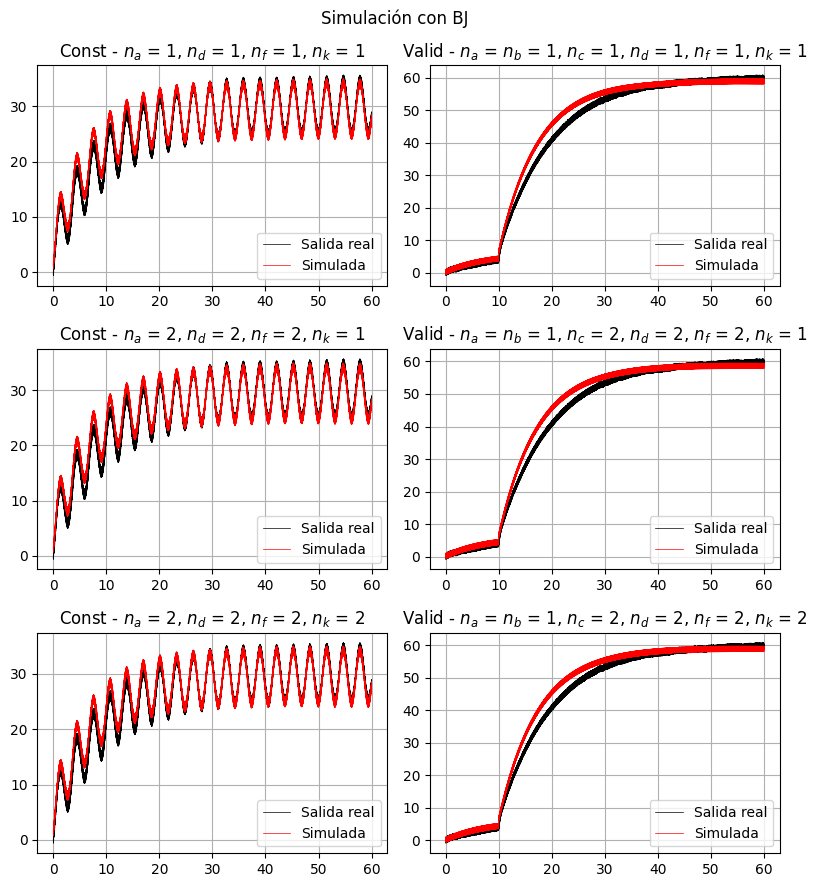

In [40]:
# Comparación entre simulación y real.
plt.figure(figsize=(8, 9))
plt.suptitle('Simulación con BJ')

for i in range(3):
    # Subplot para datos de construcción
    plt.subplot(3, 2, 2*i + 1)
    plt.title(f'Const - $n_a$ = {nc[i]}, $n_d$ = {nd[i]}, $n_f$ = {nc[i]}, $n_k$ = {nk[i]}')
    plt.plot(t, y, color='black', linewidth=0.5, label='Salida real')
    plt.plot(t_out, bj_list[i], color='red', linewidth=0.5, label='Simulada')
    plt.legend()
    plt.grid()

    # Subplot para datos de validación
    plt.subplot(3, 2, 2*i + 2)
    plt.title(f'Valid - $n_a$ = $n_b$ = {nb[i]}, $n_c$ = {nc[i]}, $n_d$ = {nd[i]}, $n_f$ = {nc[i]}, $n_k$ = {nk[i]}')
    plt.plot(t, yv, color='black', linewidth=0.5, label='Salida real')
    plt.plot(t_out, bjv_list[i], color='red', linewidth=0.5, label='Simulada')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

#### Autoregresivo con media movil y entrada exógena (ARMAX).
$$ A(z)y(n) = B(z)u(n) + C(z)e(n) ⇒ y(n) = \frac{B(z)}{A(z)}u(n) + \frac{C(z)}{A(z)}e(n) $$

In [41]:
# Crear el modelo.
na = [8, 4, 2]
nb = [4, 2, 1]
nc = [4, 2, 1]
nk = 1

armax_list = []
armaxv_list = []

for i in range(3):
  print(f' Modelo {i+1} '.center(60, '-') + f'''
  na = {na[i]}
  nb = {nb[i]}
  nc = {nc[i]}
  nk = {nk}
  ''')

  model = armax(na[i], nb[i], nc[i], nk, u, y)

  A = model.A[0,0]
  B = model.B[0,0]
  C = model.C[0,0]
  print(f'A: {A}')
  print(f'B: {B}')
  print(f'C: {C}\n')

  # Crear el sistema.
  system_1 = dlti(B, A, dt=Ts)
  system_2 = dlti(C, A, dt=Ts)

  # Crear señal predicha usando el modelo.
  t_out, y_armax_sig = dlsim(system_1, u)
  t_out, y_armax_err = dlsim(system_2, error)
  y_armax_sig = y_armax_sig.flatten()
  y_armax_err = y_armax_err.flatten()

  # Crear señal predicha con entrada de validación
  t_out, yv_armax_sig = dlsim(system_1, uv)
  yv_armax_sig = yv_armax_sig.flatten()

  # Formación del sistema completo.
  armax_list.append(y_armax_sig + y_armax_err)
  armaxv_list.append(yv_armax_sig + y_armax_err)

------------------------- Modelo 1 -------------------------
  na = 8
  nb = 4
  nc = 4
  nk = 1
  


c:\venvs\myenv\Lib\site-packages\pysid\identification\solvers.py:67: LinAlgWarning: Ill-conditioned matrix (rcond=3.39147e-25): result may not be accurate.
  theta = solve(R1, R2)


A: [ 1.         -0.70105935 -1.00739814  0.03621791  0.99918733 -0.4022532
  0.07135681  0.02053001 -0.01637799]
B: [ 0.         -0.09605876  0.40800628 -0.51222299  0.24986802 -0.04837947]
C: [ 1.          0.30235117 -0.77377047 -0.73716461  0.36561204]

------------------------- Modelo 2 -------------------------
  na = 4
  nb = 2
  nc = 2
  nk = 1
  
A: [ 1.          0.05043426 -0.96821815 -0.64821545  0.56821111]
B: [ 0.         -0.0445596   0.35506436 -0.29792056]
C: [1.         1.62152906 1.00469315]

------------------------- Modelo 3 -------------------------
  na = 2
  nb = 1
  nc = 1
  nk = 1
  
A: [ 1.         -0.20290227 -0.79462785]
B: [ 0.          0.42880431 -0.41428245]
C: [ 1.         -0.92859336]



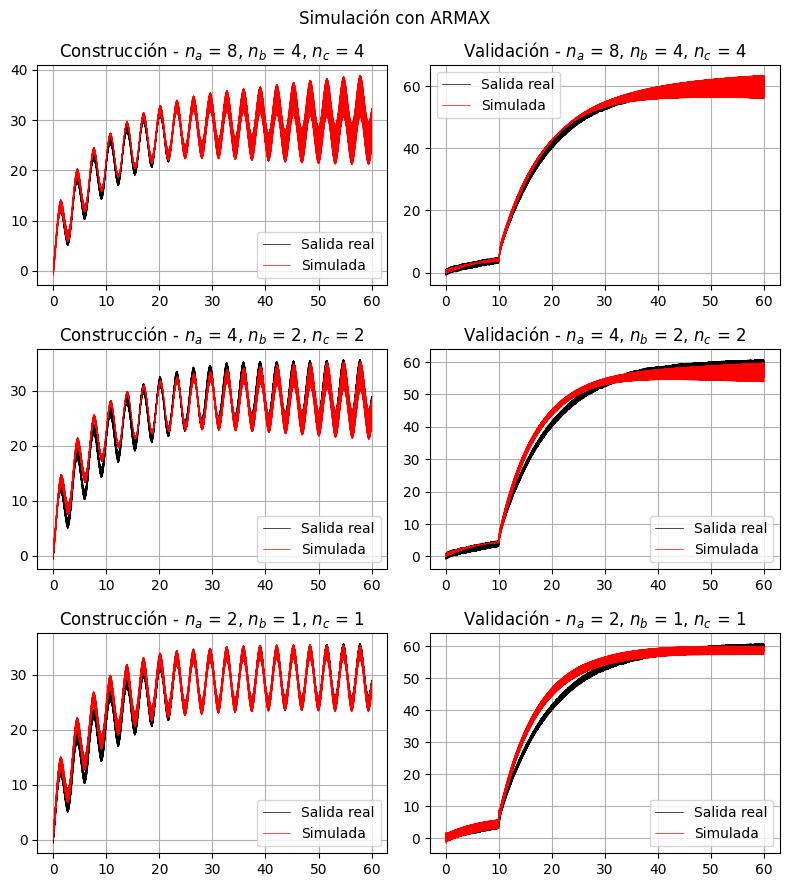

In [42]:
# Comparación entre simulación y real.
plt.figure(figsize=(8, 9))
plt.suptitle('Simulación con ARMAX')

for i in range(3):
    # Subplot para datos de construcción
    plt.subplot(3, 2, 2*i + 1)
    plt.title(f'Construcción - $n_a$ = {na[i]}, $n_b$ = {nb[i]}, $n_c$ = {nc[i]}')
    plt.plot(t, y, color='black', linewidth=0.5, label='Salida real')
    plt.plot(t_out, armax_list[i], color='red', linewidth=0.5, label='Simulada')
    plt.legend()
    plt.grid()

    # Subplot para datos de validación
    plt.subplot(3, 2, 2*i + 2)
    plt.title(f'Validación - $n_a$ = {na[i]}, $n_b$ = {nb[i]}, $n_c$ = {nc[i]}')
    plt.plot(t, yv, color='black', linewidth=0.5, label='Salida real')
    plt.plot(t_out, armaxv_list[i], color='red', linewidth=0.5, label='Simulada')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

#### Output Error (OE).
$$ y(n) = \frac{B(z)}{F(z)}u(n) + e(n) $$

In [43]:
# Crear el modelo.
nb = [4, 2, 1]
nf = [8, 4, 2]
nk = 1
oe_list = []
oev_list = []

for i in range(3):
  print(f' Modelo {i+1} '.center(60, '-') + f'''
  nb = {nb[i]}
  nf = {nf[i]}
  nk = {nk}
  ''')

  model = oe(nb[i], nf[i], nk, u, y)

  B = model.B[0,0]
  F = model.F[0,0]
  print(f'B: {B}')
  print(f'F: {F}\n')

  # Crear el sistema.
  system = dlti(B, F, dt=Ts)

  # Crear señal predicha usando el modelo.
  t_out, y_oe_sig = dlsim(system, u)
  y_oe_sig = y_oe_sig.flatten()

  # Crear señal predicha con entrada de validación
  t_out, yv_oe_sig = dlsim(system, uv)
  yv_oe_sig = yv_oe_sig.flatten()

  # Formación del sistema completo.
  oe_list.append((y_oe_sig + error))
  oev_list.append((yv_oe_sig + error))

------------------------- Modelo 1 -------------------------
  nb = 4
  nf = 8
  nk = 1
  
B: [ 0.         -0.04200703  0.57226775 -1.94154683  2.3979887  -0.98547186]
F: [ 1.00000000e+00 -1.37296099e+00  1.72700773e-01 -3.98033681e-05
  3.32420550e-01 -7.93052773e-01  1.16604879e+00 -5.04919675e-01
  7.31237170e-06]

------------------------- Modelo 2 -------------------------
  nb = 2
  nf = 4
  nk = 1
  
B: [ 0.         -0.17508837  0.43140912 -0.25500438]
F: [ 1.         -0.32147217 -1.19881941 -0.41914848  0.93965843]

------------------------- Modelo 3 -------------------------
  nb = 1
  nf = 2
  nk = 1
  
B: [ 0.          0.02383807 -0.02343244]
F: [ 1.         -1.93359951  0.93366695]



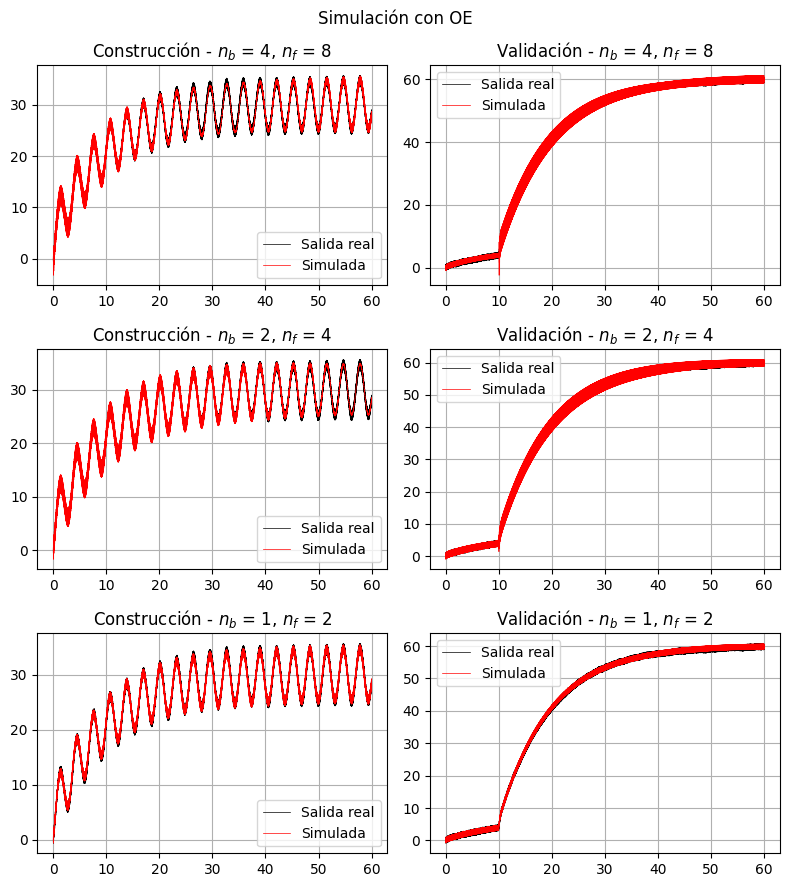

In [44]:
# Comparación entre simulación y real.
plt.figure(figsize=(8, 9))
plt.suptitle('Simulación con OE')

for i in range(3):
    # Subplot para datos de construcción
    plt.subplot(3, 2, 2*i + 1)
    plt.title(f'Construcción - $n_b$ = {nb[i]}, $n_f$ = {nf[i]}')
    plt.plot(t, y, color='black', linewidth=0.5, label='Salida real')
    plt.plot(t_out, oe_list[i], color='red', linewidth=0.5, label='Simulada')
    plt.legend()
    plt.grid()

    # Subplot para datos de validación
    plt.subplot(3, 2, 2*i + 2)
    plt.title(f'Validación - $n_b$ = {nb[i]}, $n_f$ = {nf[i]}')
    plt.plot(t, yv, color='black', linewidth=0.5, label='Salida real')
    plt.plot(t_out, oev_list[i], color='red', linewidth=0.5, label='Simulada')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

#### Autoregresivo con entrada exógena (ARX).
$$ A(z)y(n) = B(z)u(n) + e(n) ⇒ y(n) = \frac{B(z)}{A(z)}u(n) + e(n) $$

In [45]:
# Crear el modelo.
nb = [4, 2, 1]
na = [8, 4, 2]
nk = 1
arx_list = []
arxv_list = []

for i in range(3):
  print(f' Modelo {i+1} '.center(60, '-') + f'''
  na = {na[i]}
  nb = {nb[i]}
  ''')


  model = arx(na[i], nb[i], nk, u, y)

  A = model.A[0,0]
  B = model.B[0,0]
  print(f'A: {A}')
  print(f'B: {B}\n')

  # Crear el sistema.
  system = dlti(B, A, dt=Ts)

  # Crear señal predicha usando el modelo.
  t_out, y_arx_sig = dlsim(system, u)
  y_arx_sig = y_arx_sig.flatten()

  # Crear señal predicha con entrada de validación
  t_out, yv_arx_sig = dlsim(system, uv)
  yv_arx_sig = yv_arx_sig.flatten()

  # Formación del sistema completo.
  arx_list.append(y_arx_sig + error)
  arxv_list.append(yv_arx_sig + error)

------------------------- Modelo 1 -------------------------
  na = 8
  nb = 4
  
A: [ 1.         -0.73549836 -0.25897333 -0.12527263  0.44564819 -0.60299104
  0.53548714 -0.26110381  0.00420661]
B: [ 0.00000000e+00 -6.52617021e+09  1.43953774e+10 -4.03640372e+09
 -9.01332630e+09  5.18052288e+09]

------------------------- Modelo 2 -------------------------
  na = 4
  nb = 2
  
A: [ 1.         -0.05541067 -1.03345371 -0.58314849  0.67324247]
B: [ 0.         -4.60554336  9.52496137 -4.91202993]

------------------------- Modelo 3 -------------------------
  na = 2
  nb = 1
  
A: [ 1.        -0.1895259 -0.8075973]
B: [ 0.          0.43126868 -0.41587266]



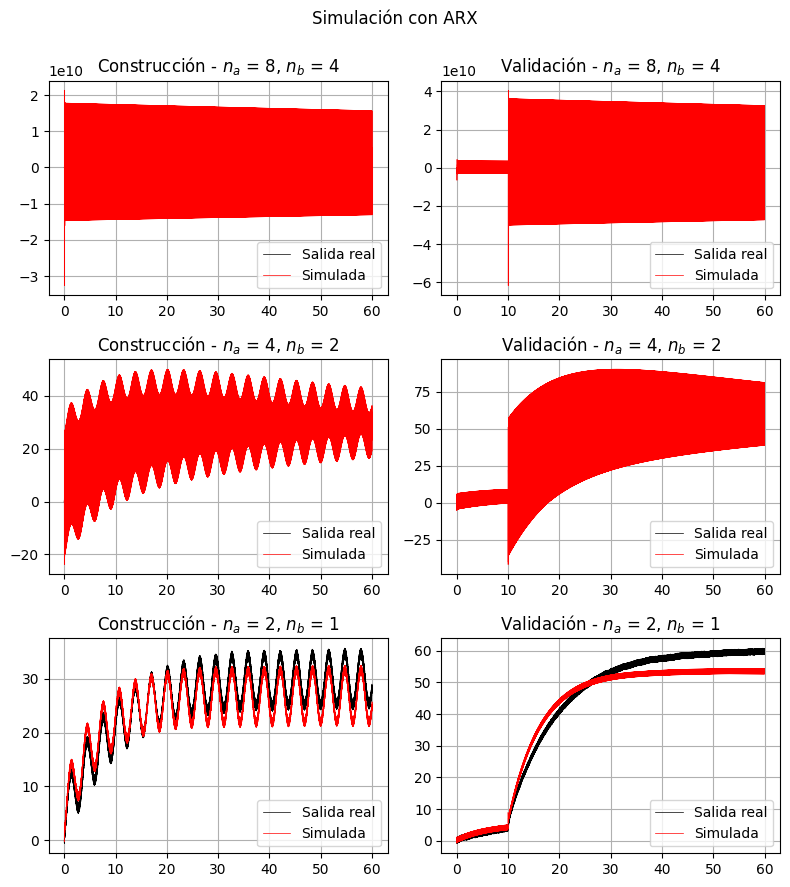

In [46]:
# Comparación entre simulación y real.
plt.figure(figsize=(8, 9))
plt.suptitle('Simulación con ARX')

for i in range(3):
    # Subplot para datos de construcción
    plt.subplot(3, 2, 2*i + 1)
    plt.title(f'Construcción - $n_a$ = {na[i]}, $n_b$ = {nb[i]}')
    plt.plot(t, y, color='black', linewidth=0.5, label='Salida real')
    plt.plot(t_out, arx_list[i], color='red', linewidth=0.5, label='Simulada')
    plt.legend()
    plt.grid()

    # Subplot para datos de validación
    plt.subplot(3, 2, 2*i + 2)
    plt.title(f'Validación - $n_a$ = {na[i]}, $n_b$ = {nb[i]}')
    plt.plot(t, yv, color='black', linewidth=0.5, label='Salida real')
    plt.plot(t_out, arxv_list[i], color='red', linewidth=0.5, label='Simulada')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

### Punto 2.
---
Calcule métricas cuantitativas que permitan evaluar el nivel de ajuste entre las estimaciones reales y predichas. Presente y justifique la elección de las métricas usadas y consolide los resultados en tablas comparativas. Analice.

In [47]:
def calcular_metricas(y_real, y_pred):
    y_real = np.asarray(y_real).flatten()
    y_pred = np.asarray(y_pred).flatten()

    # Calcular error cuadrático medio (MSE)
    mse = np.mean((y_real - y_pred)**2)

    # Calcular error absoluto medio (MAE)
    mae = np.mean(np.abs(y_real - y_pred))

    # Calcular correlación de Pearson
    corr, _ = pearsonr(y_real, y_pred)

    return {
        'MSE': mse,
        'MAE': mae,
        'Correlación': corr
    }

#### Métricas: Box Jenkins (BJ).

In [48]:
# Listas donde se guardarán los resultados
metricas_bj_cons = []
metricas_bj_val = []

# Calcular y almacenar las métricas para cada modelo
for i in range(3):
    met_ent = calcular_metricas(y, bj_list[i])
    met_val = calcular_metricas(yv, bjv_list[i])
    metricas_bj_cons.append(met_ent)
    metricas_bj_val.append(met_val)

# Imprimir resultados
print("MÉTRICAS DE DESEMPEÑO - ESTRUCTURA BOX-JENKINS")

for i in range(3):
    print(f"\nModelo {i+1}:")
    print(" - Construcción:")
    for clave, valor in metricas_bj_cons[i].items():
        print(f"    {clave}: {valor:.4f}")
    
    print(" - Validación:")
    for clave, valor in metricas_bj_val[i].items():
        print(f"    {clave}: {valor:.4f}")


MÉTRICAS DE DESEMPEÑO - ESTRUCTURA BOX-JENKINS

Modelo 1:
 - Construcción:
    MSE: 2.7471
    MAE: 1.2527
    Correlación: 0.9783
 - Validación:
    MSE: 6.4898
    MAE: 1.9075
    Correlación: 0.9950

Modelo 2:
 - Construcción:
    MSE: 2.5761
    MAE: 1.1927
    Correlación: 0.9798
 - Validación:
    MSE: 6.1973
    MAE: 1.8505
    Correlación: 0.9951

Modelo 3:
 - Construcción:
    MSE: 2.4868
    MAE: 1.1616
    Correlación: 0.9810
 - Validación:
    MSE: 6.0011
    MAE: 1.8067
    Correlación: 0.9956


#### Métricas: Autoregresivo con media movil y entrada exógena (ARMAX).

In [49]:
# Listas donde se guardarán los resultados
metricas_armax_cons = []
metricas_armax_val = []

# Calcular y almacenar las métricas para cada modelo
for i in range(3):
    met_ent = calcular_metricas(y, armax_list[i])
    met_val = calcular_metricas(yv, armaxv_list[i])
    metricas_armax_cons.append(met_ent)
    metricas_armax_val.append(met_val)

#Imprimir resultados
print("MÉTRICAS DE DESEMPEÑO - ESTRUCTURA ARMAX")

for i in range(3):
    print(f"\nModelo {i+1}:")
    print(" - Construcción:")
    for k, v in metricas_armax_cons[i].items():
        print(f"    {k}: {v:.4f}")
    print(" - Validación:")
    for k, v in metricas_armax_val[i].items():
        print(f"    {k}: {v:.4f}")

MÉTRICAS DE DESEMPEÑO - ESTRUCTURA ARMAX

Modelo 1:
 - Construcción:
    MSE: 3.9291
    MAE: 1.6614
    Correlación: 0.9588
 - Validación:
    MSE: 2.6821
    MAE: 1.3737
    Correlación: 0.9974

Modelo 2:
 - Construcción:
    MSE: 3.4179
    MAE: 1.4766
    Correlación: 0.9705
 - Validación:
    MSE: 6.4361
    MAE: 1.9917
    Correlación: 0.9937

Modelo 3:
 - Construcción:
    MSE: 2.1574
    MAE: 1.0561
    Correlación: 0.9842
 - Validación:
    MSE: 5.8551
    MAE: 1.8137
    Correlación: 0.9956


#### Métricas: Output Error (OE).

In [50]:
# Listas donde se guardarán los resultados
metricas_oe_cons = []
metricas_oe_val = []

# Calcular y almacenar las métricas para cada modelo
for i in range(3):
    met_ent = calcular_metricas(y, oe_list[i])
    met_val = calcular_metricas(yv, oev_list[i])
    metricas_oe_cons.append(met_ent)
    metricas_oe_val.append(met_val)

#Imprimir resultados
print("MÉTRICAS DE DESEMPEÑO - ESTRUCTURA OE")

for i in range(3):
    print(f"\nModelo {i+1}:")
    print(" - Construcción:")
    for k, v in metricas_oe_cons[i].items():
        print(f"    {k}: {v:.4f}")
    print(" - Validación:")
    for k, v in metricas_oe_val[i].items():
        print(f"    {k}: {v:.4f}")


MÉTRICAS DE DESEMPEÑO - ESTRUCTURA OE

Modelo 1:
 - Construcción:
    MSE: 0.8864
    MAE: 0.7236
    Correlación: 0.9907
 - Validación:
    MSE: 1.9630
    MAE: 1.1114
    Correlación: 0.9979

Modelo 2:
 - Construcción:
    MSE: 2.2743
    MAE: 1.3001
    Correlación: 0.9761
 - Validación:
    MSE: 3.8012
    MAE: 1.7057
    Correlación: 0.9959

Modelo 3:
 - Construcción:
    MSE: 1.1263
    MAE: 0.9112
    Correlación: 0.9881
 - Validación:
    MSE: 1.1024
    MAE: 0.9076
    Correlación: 0.9988


#### Métricas: Autoregresivo con entrada exógena (ARX).

In [51]:
# Listas donde se guardarán los resultados
metricas_arx_cons = []
metricas_arx_val = []

# Calcular y almacenar las métricas para cada modelo
for i in range(3):
    met_ent = calcular_metricas(y, arx_list[i])
    met_val = calcular_metricas(yv, arxv_list[i])
    metricas_arx_cons.append(met_ent)
    metricas_arx_val.append(met_val)

#Imprimir resultados
print("MÉTRICAS DE DESEMPEÑO - ESTRUCTURA ARX")

for i in range(3):
    print(f"\nModelo {i+1}:")
    print(" - Construcción:")
    for k, v in metricas_arx_cons[i].items():
        print(f"    {k}: {v:.4f}")
    print(" - Validación:")
    for k, v in metricas_arx_val[i].items():
        print(f"    {k}: {v:.4f}")


MÉTRICAS DE DESEMPEÑO - ESTRUCTURA ARX

Modelo 1:
 - Construcción:
    MSE: 139828538676206845952.0000
    MAE: 10803420974.2203
    Correlación: -0.0958
 - Validación:
    MSE: 494180527478206169088.0000
    MAE: 18908018315.4388
    Correlación: -0.0287

Modelo 2:
 - Construcción:
    MSE: 160.9172
    MAE: 11.0079
    Correlación: 0.4070
 - Validación:
    MSE: 562.6118
    MAE: 19.7556
    Correlación: 0.6573

Modelo 3:
 - Construcción:
    MSE: 7.1617
    MAE: 2.3923
    Correlación: 0.9569
 - Validación:
    MSE: 16.1183
    MAE: 3.4592
    Correlación: 0.9897


### Punto 3.
---
De acuerdo con los resultados, seleccione el mejor modelo y presente la expresión final del sistema.

In [52]:
def encontrar_mejor_modelo(metricas_dict, criterio='MSE', peso_ent=0.5, peso_val=0.5):
    
    mejor_valor = float('inf') if criterio != 'Correlación' else -1
    mejor_modelo = None
    mejor_idx = None

    for nombre_modelo, metricas in metricas_dict.items():
        for idx in range(len(metricas['ent'])):
            valor_ent = metricas['ent'][idx][criterio]
            valor_val = metricas['val'][idx][criterio]

            # Valor combinado (promedio ponderado)
            if criterio != 'Correlación':
                valor_combinado = peso_ent * valor_ent + peso_val * valor_val
                es_mejor = valor_combinado < mejor_valor
            else:
                valor_combinado = peso_ent * valor_ent + peso_val * valor_val
                es_mejor = valor_combinado > mejor_valor

            if es_mejor:
                mejor_valor = valor_combinado
                mejor_modelo = nombre_modelo
                mejor_idx = idx

    return mejor_modelo, mejor_idx, mejor_valor



In [53]:
metricas_dict = {
    'BJ': {'ent': metricas_bj_cons, 'val': metricas_bj_val},
    'ARMAX': {'ent': metricas_armax_cons, 'val': metricas_armax_val},
    'OE': {'ent': metricas_oe_cons, 'val': metricas_oe_val},
    'ARX': {'ent': metricas_arx_cons, 'val': metricas_arx_val},
}


In [54]:
# Evaluar considerando ambos conjuntos, 50% peso cada uno

# Buscar el mejor modelo según el MSE en validación
modelo, idx, valor = encontrar_mejor_modelo(metricas_dict, criterio='MSE', peso_ent=0.5, peso_val=0.5)
print(f"\nMejor modelo según MSE (promedio entre construcción y validación): {modelo}, configuración #{idx+1}, con valor combinado = {valor:.4f}")

# Buscar el mejor modelo según el MAE en validación
modelo, idx, valor = encontrar_mejor_modelo(metricas_dict, criterio='MAE', peso_ent=0.5, peso_val=0.5)
print(f"\nMejor modelo según MAE (promedio entre construcción y validación): {modelo}, configuración #{idx+1}, con valor combinado = {valor:.4f}")

# Buscar el mejor modelo según la correlación en validación
modelo, idx, valor = encontrar_mejor_modelo(metricas_dict, criterio='Correlación', peso_ent=0.5, peso_val=0.5)
print(f"\nMejor modelo según Correlación (promedio entre construcción y validación): {modelo}, configuración #{idx+1}, con valor combinado = {valor:.4f}")



Mejor modelo según MSE (promedio entre construcción y validación): OE, configuración #3, con valor combinado = 1.1144

Mejor modelo según MAE (promedio entre construcción y validación): OE, configuración #3, con valor combinado = 0.9094

Mejor modelo según Correlación (promedio entre construcción y validación): OE, configuración #1, con valor combinado = 0.9943


### Expresión final del sistema identificado

**Modelo seleccionado:** OE – Configuración #3  
**Criterio de selección:** Evaluación combinada en conjuntos de construcción y validación  
**Motivo de selección:** Este modelo obtuvo el mejor desempeño en 2 de los 3 criterios analizados (MSE y MAE) al promediar los resultados de construcción y validación.

**Parámetros:**  
- $$n_b = 1 $$
- $$n_f = 2 $$
- $$ n_k = 1 $$

**Polinomios identificados:**  
- $$ B(q^{-1}) = 0.02383807 q^{-1} - 0.02343244 q^{-2} $$
- $$ F(q^{-1}) = 1 - 1.93359951 q^{-1} + 0.93366695 q^{-2} $$

**Expresión en función del operador \( z^{-1} \):**

$$
Y(z) = \frac{0.02383807 \, z^{-1} - 0.02343244 \, z^{-2}}{1 - 1.93359951 \, z^{-1} + 0.93366695 \, z^{-2}} \, U(z)
$$

*Este modelo fue seleccionado tras un análisis global considerando tanto el error en la fase de construcción como en la de validación, utilizando MSE, MAE y correlación como criterios de comparación.*


